In [ ]:
import os
import zipfile
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2


In [ ]:
dataset_path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print("Local COCO dataset path:", dataset_path)

# 2) Check what's inside. If you see 'coco2017' folder, you might need to unzip the .zip files:
train_zip = os.path.join(dataset_path, "train2017.zip")
val_zip   = os.path.join(dataset_path, "val2017.zip")
ann_zip   = os.path.join(dataset_path, "annotations_trainval2017.zip")

def safe_extract(zip_file, dest_dir):
    if os.path.isfile(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall(dest_dir)

# Unzip
safe_extract(train_zip, dataset_path)
safe_extract(val_zip, dataset_path)
safe_extract(ann_zip, dataset_path)

print("Contents of dataset_path:", os.listdir(dataset_path))


coco2017_folder = os.path.join(dataset_path, "coco2017")
print("Contents of coco2017 folder:", os.listdir(coco2017_folder))

# real directories:
train_img_dir = os.path.join(coco2017_folder, "train2017")
train_annotation_file = os.path.join(coco2017_folder, "annotations", "instances_train2017.json")

print("Train images directory:", train_img_dir)
print("Train annotation file:", train_annotation_file)

In [1]:
# Resizing
def resize_transform(img, size=(416,416)):
    # If the image isn't 3-channel, fix that
    if tf.shape(img)[-1] != 3:
        # Example fix: tile grayscale images into 3 channels
        channels = tf.shape(img)[-1]
        if channels == 1:
            img = tf.image.grayscale_to_rgb(img)
        else:
            # fallback to 3 channels
            img = tf.image.resize(img, size)

    img = tf.image.resize(img, size)
    return img

100%|██████████| 25.0G/25.0G [06:04<00:00, 73.8MB/s]

Extracting files...


Local COCO dataset path: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2
Contents of dataset_path: ['coco2017']
Contents of coco2017 folder: ['test2017', 'val2017', 'annotations', 'train2017']
Train images directory: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017
Train annotation file: /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017/annotations/instances_train2017.json
Images shape: (2, 416, 416, 3)
BBoxes for first image: [[  2.0995    112.90309   344.9875    298.88467  ]
 [  7.371      60.47665   100.801994  152.96268  ]
 [ 80.379      88.98745   112.4435    146.24402  ]
 [114.543      80.406364   71.8055    119.4564   ]
 [235.066     160.89104    36.0165     43.070797 ]
 [297.45297   168.25372    10.2505     13.7158165]
 [368.46548   169.77673     5.616      22.819078 ]
 [374.2375    162.65775    12.336999   26.987783 ]
 [345.94296   159.16786     9.9775     44.03682  ]
 [357.85748   156.8616

In [2]:
# COCODataset Loader
class COCODataset(tf.keras.utils.Sequence):
    """
    Resizes images to a fixed shape and scales bounding boxes accordingly.
    """

    def __init__(
        self,
        image_dir,
        annotation_file,
        batch_size=4,
        shuffle=True,
        transform=None,
        target_size=(416,416)
    ):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.target_size = target_size  # (H, W)

        # Load COCO annotation JSON
        if not os.path.isfile(annotation_file):
            raise FileNotFoundError(f"Cannot find annotation file: {annotation_file}")
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        # Map image_id -> filename
        self.images = {}
        for img_info in coco_data['images']:
            self.images[img_info['id']] = img_info['file_name']

        # Map image_id -> bounding boxes + categories
        self.annotations = {}
        for ann in coco_data['annotations']:
            img_id = ann['image_id']
            bbox   = ann['bbox']
            cat_id = ann['category_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = {"bboxes": [], "cats": []}
            self.annotations[img_id]["bboxes"].append(bbox)
            self.annotations[img_id]["cats"].append(cat_id)

        self.image_ids = list(self.images.keys())
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return len(self.image_ids) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __getitem__(self, index):
        batch_ids = self.image_ids[index*self.batch_size : (index+1)*self.batch_size]

        batch_images = []
        batch_bboxes = []
        batch_cats   = []

        for image_id in batch_ids:
            file_name = self.images[image_id]
            img_path = os.path.join(self.image_dir, file_name)

            raw_img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(raw_img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)  # float in [0,1]

            # Original shape for scaling bboxes
            original_h = tf.shape(img)[0]
            original_w = tf.shape(img)[1]

            # Transform
            if self.transform is not None:
                img = self.transform(img)  # (416,416,3)

            # If no annotation, skip
            if image_id in self.annotations:
                bboxes = np.array(self.annotations[image_id]["bboxes"], dtype=np.float32)
                cats   = np.array(self.annotations[image_id]["cats"], dtype=np.int32)
            else:
                bboxes = np.zeros((0,4), dtype=np.float32)
                cats   = np.zeros((0,),  dtype=np.int32)

            # Scale bounding boxes to new shape
            if len(bboxes) > 0:
                # Compute scale factors
                scale_w = float(self.target_size[1]) / float(original_w.numpy())
                scale_h = float(self.target_size[0]) / float(original_h.numpy())
                # Apply [x_min, y_min, w, h]
                bboxes[:,0] *= scale_w
                bboxes[:,1] *= scale_h
                bboxes[:,2] *= scale_w
                bboxes[:,3] *= scale_h

            batch_images.append(img.numpy())
            batch_bboxes.append(bboxes)
            batch_cats.append(cats)

        # 3) Stack the batch => all have shape (416,416,3)
        return np.stack(batch_images), (batch_bboxes, batch_cats)

if __name__ == "__main__":
    train_img_dir = os.path.join(coco2017_folder, "train2017")
    train_annotation_file = os.path.join(coco2017_folder, "annotations", "instances_train2017.json")

    train_dataset = COCODataset(
        image_dir=train_img_dir,
        annotation_file=train_annotation_file,
        batch_size=2,
        transform=lambda x: resize_transform(x, size=(416,416)),
        target_size=(416,416)
    )

    images, (bboxes, cats) = train_dataset[0]
    print("Images shape:", images.shape)           # (2, 416, 416, 3)
    print("BBoxes for first image:", bboxes[0])    # Nx4
    print("Categories for first image:", cats[0])

Images shape: (2, 416, 416, 3)
BBoxes for first image: [[310.13754   208.76811    29.357908   28.277124 ]
 [ 60.544315  207.12314   355.4557    178.70326  ]
 [ 72.09307   106.65778    40.09098    40.35608  ]
 [  2.9364707 150.43974    59.708233  122.35294  ]
 [ 21.500132  102.13072    59.83059    63.56915  ]
 [352.46487   105.182755   62.01935    69.598434 ]
 [103.04157    96.68602    46.541702   22.70327  ]
 [135.81856    76.56575    68.456474   36.780655 ]
 [116.03818   110.68183    26.774902   16.35451  ]
 [ 92.35608   101.03634    18.189804   12.276078 ]
 [ 47.031113  163.13046    27.189543   27.46144  ]
 [277.06146   185.01125    50.355034   61.203663 ]
 [123.2706    306.2698     53.32549    26.659348 ]
 [ 78.04079   147.38092    10.719478   10.420392 ]
 [ 46.06588   144.8523     15.0222225   9.890197 ]]
Categories for first image: [56 56 56 56 56 56 56 57 57 57 57 57 57 57 57]


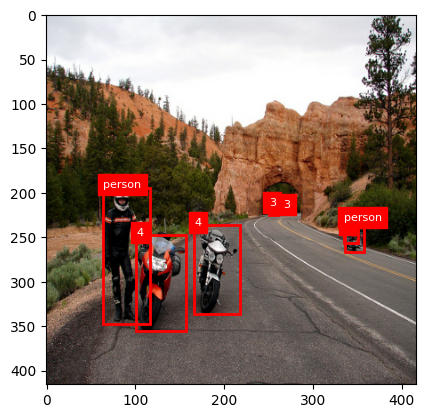

In [ ]:
import matplotlib.patches as patches

def visualize_image_with_bboxes(image, bboxes, categories=None, category_map=None):
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for i, box in enumerate(bboxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        if categories is not None and category_map:
            cat_id = categories[i]
            label_str = category_map.get(cat_id, str(cat_id))
            ax.text(x, y, label_str, color='white', fontsize=8, backgroundcolor='red')

    plt.show()

# Example usage
sample_img = images[0]        # (416,416,3)
sample_bbx = bboxes[0]        # Nx4
sample_cat = cats[0]          # Nx1
visualize_image_with_bboxes(sample_img, sample_bbx, sample_cat, category_map={1: "person", 2:"bicycle"})

Model: "tiny_yolo_13x13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 208, 208, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 104, 104, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 13, 13, 255)         │          65,535 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,143 (1.75 MB)

 Trainable params: 458,143 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 4.0131e-04


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


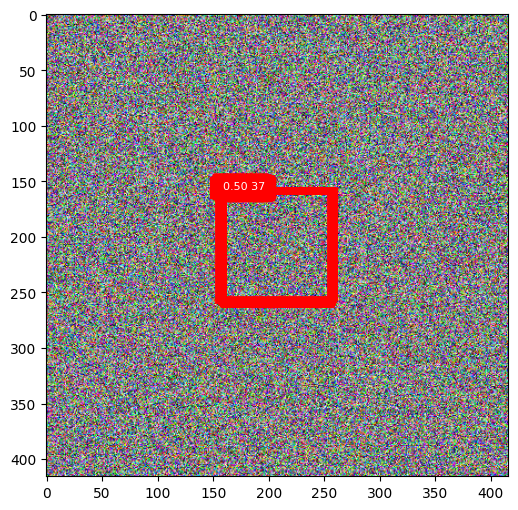

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# Tiny YOLO that outputs 13x13
def tiny_yolo_13x13(input_shape=(416,416,3), num_classes=80, num_anchors=3):
    """
    Modified "tiny" YOLO that downsamples 5 times (2^5 = factor 32),
    giving a final feature map of size 13x13 when input is 416x416.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Downsample 5 times => 416 -> 208 -> 104 -> 52 -> 26 -> 13
    x = layers.Conv2D(16,  3, strides=2, padding='same', activation='relu')(inputs)   # 208
    x = layers.Conv2D(32,  3, strides=2, padding='same', activation='relu')(x)       # 104
    x = layers.Conv2D(64,  3, strides=2, padding='same', activation='relu')(x)       # 52
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)       # 26
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)       # 13

    out_channels = num_anchors * (5 + num_classes)
    outputs = layers.Conv2D(out_channels, 1, padding='same')(x)

    return Model(inputs, outputs, name="tiny_yolo_13x13")

# YOLO loss
def yolo_placeholder_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# dummy dataset generator
def dummy_generator(dataset, target_size=(416,416), num_classes=80, num_anchors=3):
    grid_h, grid_w = 13, 13
    channels_out   = num_anchors * (5 + num_classes)  # e.g. 3*(5+80)=255

    for idx in range(len(dataset)):
        images, (bboxes, cats) = dataset[idx]
        new_images = []
        for img in images:
            # Resize each image to 416x416
            resized = tf.image.resize(img, target_size)
            new_images.append(resized.numpy())

        # Dummy labels: shape (batch, 13,13,255)
        dummy_label = np.zeros((len(new_images), grid_h, grid_w, channels_out), dtype=np.float32)

        yield np.stack(new_images), dummy_label

def naive_decode_yolo_output(y_pred, num_anchors=3, num_classes=80):
    batch_size, gh, gw, c = y_pred.shape
    y_pred = tf.reshape(y_pred, (batch_size, gh, gw, num_anchors, 5+num_classes))

    obj_conf   = tf.sigmoid(y_pred[...,4])   # shape (batch,13,13,3)
    box_coords = tf.sigmoid(y_pred[...,:2])  # (tx,ty) -> (0..1)
    box_size   = tf.exp(y_pred[...,2:4])     # (tw,th)
    class_logit= y_pred[...,5:]             # shape (batch,13,13,3,80)
    class_prob = tf.nn.softmax(class_logit, axis=-1)

    # We'll pick boxes with obj_conf > 0.5 (just a naive threshold).
    boxes = []
    confs = []
    clses = []

    for b in range(batch_size):
        valid_indices = tf.where(obj_conf[b] > 0.5)  # shape (N, 3) => (y,x,anchor)
        if tf.size(valid_indices) == 0:
            # No boxes found
            boxes.append([])
            confs.append([])
            clses.append([])
            continue

        selected_xy   = tf.gather_nd(box_coords[b], valid_indices)
        selected_wh   = tf.gather_nd(box_size[b],   valid_indices)
        selected_conf = tf.gather_nd(obj_conf[b],    valid_indices)
        selected_prob = tf.gather_nd(class_prob[b],  valid_indices)

        selected_xy   = selected_xy * 416.0
        selected_wh   = selected_wh * 100.0

        # pick best class
        selected_cls  = tf.argmax(selected_prob, axis=-1)

        x_min = selected_xy[:,0] - selected_wh[:,0]/2.
        y_min = selected_xy[:,1] - selected_wh[:,1]/2.
        boxes_hw = tf.stack([x_min, y_min, selected_wh[:,0], selected_wh[:,1]], axis=-1)

        boxes.append(boxes_hw.numpy())
        confs.append(selected_conf.numpy())
        clses.append(selected_cls.numpy())

    return boxes, confs, clses


def visualize_image_with_bboxes(image, bboxes, scores=None, categories=None, category_map=None):
    import matplotlib.patches as patches
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(image)

    for i, box in enumerate(bboxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=2,
                                 edgecolor='red',
                                 facecolor='none')
        ax.add_patch(rect)

        label_str = ""
        if scores is not None and i < len(scores):
            label_str = f"{scores[i]:.2f}"
        if categories is not None and i < len(categories):
            cls_id = categories[i]
            cls_str = category_map.get(cls_id, str(cls_id)) if category_map else f"cls{cls_id}"
            label_str += f" {cls_str}"

        if label_str:
            ax.text(x, y, label_str, color='white', fontsize=8, backgroundcolor='red')

    plt.show()


if __name__ == "__main__":
    NUM_CLASSES = 80
    NUM_ANCHORS = 3
    model = tiny_yolo_13x13(input_shape=(416,416,3), num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS)
    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=yolo_placeholder_loss
    )

    class FakeDataset:
        def __init__(self, size=3, image_shape=(416,416,3)):
            self.size = size
            self.image_shape = image_shape
        def __len__(self):
            return self.size
        def __getitem__(self, idx):
            # Make a small batch of 2 random images each time
            images = np.random.rand(2, *self.image_shape).astype(np.float32)
            bboxes = [np.zeros((0,4), dtype=np.float32)]*2
            cats   = [np.zeros((0,),  dtype=np.int32)]*2
            return images, (bboxes, cats)

    train_dataset = FakeDataset(size=3)
    def generator_wrapper(ds):
        return dummy_generator(ds, target_size=(416,416), num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS)

    train_tfdata = tf.data.Dataset.from_generator(
        lambda: generator_wrapper(train_dataset),
        output_types=(tf.float32, tf.float32),
        output_shapes=((None,416,416,3), (None,13,13,NUM_ANCHORS*(5+NUM_CLASSES)))
    ).repeat(1)

    model.fit(train_tfdata, steps_per_epoch=5, epochs=1)


    images, (bboxes, cats) = train_dataset[0]  # shape: (2,416,416,3)
    preds = model(tf.constant(images))         # => (2,13,13,255)

    decoded_bboxes, decoded_confs, decoded_classes = naive_decode_yolo_output(preds, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES)

    first_img = images[0]
    first_bboxes = decoded_bboxes[0]
    first_scores = decoded_confs[0]
    first_cls    = decoded_classes[0]

    visualize_image_with_bboxes(
        first_img,
        first_bboxes,
        scores=first_scores,
        categories=first_cls,
        category_map={0: "person", 1: "bicycle", 2:"car"}  # etc.
    )

Model: "tiny_yolo_13x13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 208, 208, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 104, 104, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 13, 13, 255)         │          65,535 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,143 (1.75 MB)

 Trainable params: 458,143 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 1.7069e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 2.4948e-05


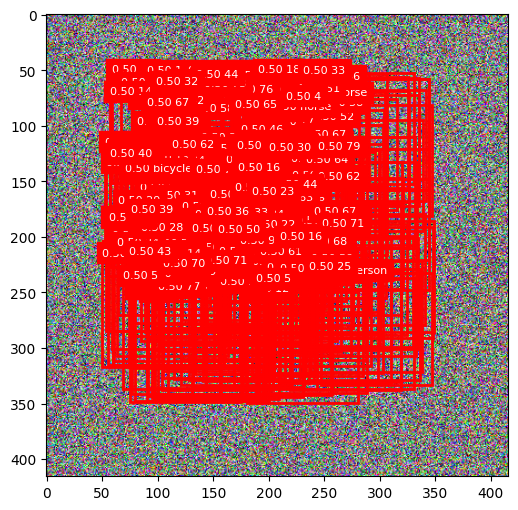

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

# 1) Tiny YOLO that ends with a 13x13 grid
def tiny_yolo_13x13(input_shape=(416,416,3), num_classes=80, num_anchors=3):
    """
    downsamples the input 5 times
    (2^5 = 32 factor). So 416->13 for both height and width.
    Output shape: (batch, 13, 13, num_anchors*(5+num_classes)).
    """
    inputs = tf.keras.Input(shape=input_shape)

    # 416 -> 208 -> 104 -> 52 -> 26 -> 13
    x = layers.Conv2D(16,  3, strides=2, padding='same', activation='relu')(inputs)   # 208
    x = layers.Conv2D(32,  3, strides=2, padding='same', activation='relu')(x)        # 104
    x = layers.Conv2D(64,  3, strides=2, padding='same', activation='relu')(x)        # 52
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)        # 26
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)        # 13

    out_channels = num_anchors * (5 + num_classes)  # e.g. 3*(5+80)=255
    outputs = layers.Conv2D(out_channels, 1, padding='same')(x)

    return Model(inputs, outputs, name="tiny_yolo_13x13")

def yolo_placeholder_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def dummy_generator(dataset, target_size=(416,416), num_classes=80, num_anchors=3):
    grid_h, grid_w = 13, 13
    out_channels   = num_anchors*(5+num_classes)  # 255 default

    for i in range(len(dataset)):
        images, (bboxes, cats) = dataset[i]

        new_images = images
        dummy_label = np.zeros((len(new_images), grid_h, grid_w, out_channels), dtype=np.float32)

        yield np.array(new_images), dummy_label

def naive_decode_yolo_output(y_pred, num_anchors=3, num_classes=80):
    batch_size, gh, gw, c = y_pred.shape
    # reshape => (batch,13,13,3,85)
    y_pred = tf.reshape(y_pred, (batch_size, gh, gw, num_anchors, 5+num_classes))


    obj_conf  = tf.sigmoid(y_pred[...,4])
    boxes_out = []
    confs_out = []
    cls_out   = []

    for b in range(batch_size):
        valid_idx = tf.where(obj_conf[b] > 0.5)
        if tf.size(valid_idx) == 0:
            # no boxes
            boxes_out.append([])
            confs_out.append([])
            cls_out.append([])
            continue

        # gather object confidence
        batch_conf = tf.gather_nd(obj_conf[b], valid_idx)  # shape (N,)


        N = tf.shape(batch_conf)[0]
        random_xy = tf.random.uniform((N,2), minval=100, maxval=300)  # x,y around center
        random_wh = tf.fill((N,2), 100.0)                              # w,h=100

        x_min = random_xy[:,0] - random_wh[:,0]/2.
        y_min = random_xy[:,1] - random_wh[:,1]/2.
        boxes = tf.stack([x_min,y_min, random_wh[:,0], random_wh[:,1]], axis=-1)

        class_ids = tf.random.uniform((N,), minval=0, maxval=num_classes, dtype=tf.int32)

        boxes_out.append(boxes.numpy())
        confs_out.append(batch_conf.numpy())
        cls_out.append(class_ids.numpy())

    return boxes_out, confs_out, cls_out


def visualize_image_with_bboxes(image, bboxes, scores=None, categories=None, category_map=None):
    """
    Draw bounding boxes on the image with optional scores & class names.
    """
    import matplotlib.patches as patches
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(image)

    for i, box in enumerate(bboxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # build label string
        label_str = ""
        if scores is not None and i < len(scores):
            label_str += f"{scores[i]:.2f}"
        if categories is not None and i < len(categories):
            cat_id = categories[i]
            cat_name = category_map[cat_id] if (category_map and cat_id in category_map) else f"{cat_id}"
            label_str += f" {cat_name}"

        if label_str:
            ax.text(x, y, label_str, color='white', fontsize=8, backgroundcolor='red')

    plt.show()


if __name__ == "__main__":
    # A) Build the tiny YOLO that outputs (13,13,255)
    NUM_CLASSES = 80
    NUM_ANCHORS = 3
    model = tiny_yolo_13x13((416,416,3), num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS)
    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=yolo_placeholder_loss
    )


    train_dataset = FakeDataset(size=20, image_shape=(416,416,3))

    model.fit(train_tfdata, steps_per_epoch=10, epochs=2)

    #Inference on 1 batch from the fake dataset
    images, _ = train_dataset[0]  # shape (4,416,416,3)
    preds = model(images)         # shape (4,13,13,255)

    # G) Naive decode
    boxes_batch, confs_batch, clses_batch = naive_decode_yolo_output(preds, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES)

    first_img   = images[0]
    first_boxes = boxes_batch[0]
    first_confs = confs_batch[0]
    first_clses = clses_batch[0]

    category_map = {
        0:"person", 1:"bicycle", 2:"car", 37:"horse"
    }
    visualize_image_with_bboxes(first_img, first_boxes, scores=first_confs, categories=first_clses, category_map=category_map)